### Details:
* Author: Gayathri Nadar (Scientific Computing Facility, MPI-CBG)
* Date: 2021-10
* For: Ksenia (Vastenhouw lab)
* Sections of notebook adapted from Noreen Walker (Scientific Computing Facility, MPI-CBG)'s work https://git.mpi-cbg.de/scicomp/bioimage_team/mauricio_norden_lightsheetpreprocessing

### About
* This notebook is used to define **crop regions of interest (Roi)** for time-lapse data.
* **A time-lapse movie prepared from files in a folder is loaded** 
* **The user can then interactively draw the Roi for cropping in the X, Y dimension.**
* **The Roi is then used to crop the time-lapse movie**
* **Finally the cropped image is normalized in a single channel**
* The normalized image is also drift corrected in the specified channel and if specified, the other channel of the 2 is registered to the drift corrected channel. 

### Data:
* **Input**
    * folder containing max-projected *tif* files (*.tif*) obtained as output from CARE prediction. 
    * each file has n time points so a sequence has no of files x n time points in total.
        * Allowed dimensions per file: TCYX, time-points, 2 channels, y, x
    * sometimes the last image has less no of time points. In that case the sequence has Timepoints = t1 + t2 + t3 + ... + tn where tx = no time points in each file
    * **both cases described above is analyzable.**
    * **single image is also analyzable**. Specify the path in `datadir` accordingly.
    * calibration to be set for the image: **X, Y pixel size in um and time interval in seconds**
* **Output** </br>
 Images are saved in folder `datadirName_output` outside of `datadir`:
 
    * whole image with calibration TCYX
    * cropped image with all dimensions TCYX 
    * cropped normalized image of the specified channel TYX
    * cropped normalized drift corrected image of the specified channel TYX
    * cropped normalized drift corrected image of the other channel TYX
    * cropped normalized drift corrected hyperstack image with 2 channels CTYX

### Usage
* Make sure to have the this notebook and the the *imgprocessing_functions.py* in the same folder
* Click through the cells and:
    * Specify input directory and optional other parameters below.
    * Specify the channel to process, and for each channel run through all cells downstream of the `specify channel` cell.

### Background info
* Most relevant **Used libraries**:
    * `numpy`: image (matrix) processing
    * `napari`: Interactive image visualization
    * `tifffile`: saving data 
        * docs: *help(tifffile)* and 
        https://forum.image.sc/t/python-copy-all-metadata-from-one-multipage-tif-to-another/26597/8
    * `pystackreg`: drift correction
* **Getting Help for a function**: Type `help(myfunction)` or `myfunction??` into a new cell and run that cell.


### Workflow
- read images from the folder specified
    - ask user to specify folder and calibration 
    - image dimensions of entire sequence = XYCT (C= 2 and T = t1 + t2 + t3 + ... + tn, tx = no time points in each file)
- load array into napari for viewing
    - ask user to define roi for cropping 
    - get roi 
- crop image
    - ask user to specify time range for cropping 
    - get coordinates for xmin, ymin, xmax, ymax for cropping from roi + time 
    - crop image 
- cropped image normalization 
    - ask user to specify channel to normalize 
    - normalize cropped image using histogram of xyt 
- cropped image registration 
    - drift correct in the normalized image in specified channel (channel specified for normalize)
    - ask user if they want to register the other channel to other drift corrected channel 
    - if yes, register other channel to first, merge into hyperstack
- save output 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tifffile
from tifffile import imread, imwrite, TiffFile, TiffSequence
from csbdeep.io import save_tiff_imagej_compatible
import glob
import os, time, re
from pystackreg import StackReg
import datetime 
from datetime import datetime 

import napari
from skimage import transform, img_as_float, exposure
from skimage.registration import phase_cross_correlation
from skimage.feature import register_translation

from imgprocessing_functions import * # all custom functions

%load_ext autoreload
%autoreload 2

In [3]:
%gui qt5
# wait 5 sec

### User Input: specify parameters

Assumptions:
- Data is 2D with TCYX dimensions 
- Each file has specific number of time-points 
- E.g. folder has 7 images each with 8 timepoints, 2 channels, 1 slice (max-projected)

Calibration information:
- The final images are saved as FIJI compatible hyperstacks
- The calibration information added here will be applied to the images when saving

!!!!!! important point: sometimes if the whole notebook is not reloaded when new image sequence is loaded - it does not register a new imagename

In [4]:
# enter the directory containing time-lapse images
# specify path with pattern + .tif
datadir = "../data_differentTP/*t000000*.tif"
# datadir = "../data_differentTP/*.tif"

# create datadir using timestamp 
outdirname = os.path.basename(os.path.dirname(datadir)) + "__output"
outputdir= os.path.join(os.path.dirname(os.path.dirname(datadir)), outdirname)      # will be created
print("Output will be saved to folder: ", outputdir)

calib = [0.196, 0.196]  # pixel size in um in X and Y, Z = 1 as we work with max-projected images
frame_interval = 40  # in seconds

Output will be saved to folder:  ../data_differentTP__output


#### Find files and display some properties 

In [29]:
filenames = loadImagesFromPath(datadir)
print("Found ",len(filenames)," image files.")

# read an image and show properties
imgsample = tifffile.imread(filenames[0])
print("Single time-lapse file shape: (TCYX)", imgsample.shape)
print("Single time-lapse file dims: (TCYX)", imgsample.ndim)
print("---------Single time point image properties----------")
print("Shape: (CYX)",  imgsample[0].shape)
print("Datatype:", imgsample[0].dtype)
print("No dimensions:", imgsample[0].ndim)

Found  1  image files.
Single time-lapse file shape: (TCYX) (8, 2, 1000, 1000)
Single time-lapse file dims: (TCYX) 4
---------Single time point image properties----------
Shape: (CYX) (2, 1000, 1000)
Datatype: uint16
No dimensions: 3


#### Create movie to process 
- Images in the specified directory are concatinated into a continuous movie sequence 

In [30]:
# read all files
image_sequence, shape_imagesequence = prepareMovieForCrop(filenames)

print("Movie size (TCYX):", shape_imagesequence) # TCYX

Movie size (TCYX): (8, 2, 1000, 1000)


In [33]:
nchannels=shape_imagesequence[1] # TCYX

# good contrast ranges
contrasts=[]
for ch in range(nchannels):
    contrasts.append([np.percentile(image_sequence[::2,ch,::5],1),np.percentile(image_sequence[::2,ch,::5],99.8)]) # use a subset

## Interactive cropping
Cropping is done in XY plane. All dimensions are visualized and cropped (TCYX).

#### Usage instructions:
* Select the Roi by clicking on it
* Either modify the Roi: Drag and scale it 
* Or: delete the Roi: click on the 'x' tool in the top left (after selecting the Roi)
* Close viewer when done

In [32]:
shapes_layer= displayForCrop(image_sequence, contrasts)

/Users/nadar/anaconda3/envs/napari_ipf/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


##### Close viewer manually

In [34]:
[ymin, ymax, xmin, xmax] = extractAndPrepRoi(shapes_layer, shape_imagesequence[2], shape_imagesequence[3])

Roi coordinates (px): top-left:( 255 , 460 ),  bottom-right: ( 510 , 723 ). Limits from image dim: :( 1000 , 1000 )


### User input: Provide time range to crop 

In [35]:
time_range_min = 0
time_range_max = 5

#### Prepare coordinates for cropping 

In [36]:
cropcoords = {}
cropcoords["xmin"] = xmin 
cropcoords["xmax"] = xmax 
cropcoords["ymin"] = ymin 
cropcoords["ymax"] = ymax 
cropcoords["tmin"] = time_range_min 
cropcoords["tmax"] = time_range_max

print("Cropping range in all dimensions: ", cropcoords)

Cropping range in all dimensions:  {'xmin': 460, 'xmax': 723, 'ymin': 255, 'ymax': 510, 'tmin': 0, 'tmax': 5}


#### Get cropped image 
Note: all dimensions are retained: TCYX (T in specified range)

In [37]:
cropped_imagesequence = cropImage(image_sequence, cropcoords)

Cropping done. Shape cropped image (TCYX):  (5, 2, 255, 263)


### Optional cell: Run the below cell to view the cropped image 
If not happy, go back and run from the **Interactive Cropping** section

In [19]:
viewer = napari.view_image(cropped_imagesequence, channel_axis=1, name='image',title="Cropped image")

/Users/nadar/anaconda3/envs/napari_ipf/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


##### Close viewer manually

## Image normalization 

- The cropped image in the specified channel is normalized using CLAHE. 
- Histogram from the specified channel of cropped image (TYX) is used to compute the values for normalization.

For different methods for histogram normalization check: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html 

- Both options CLAHE and contrast stretching is available to choose. 
- Note: CLAHE provides slightly better results

### User input: specify channel to process and normalization method

- Channel Options: 0 or 1 for channel 1 and channel 2 respectively. 
- For different channel change here and run from here
- Normalization option: enter string `"clahe"` or `"percentile"`

**Specify channel & method**

In [40]:
# additonal input - enter values 
channel_to_normalize = 1  # options 0 or 1
norm_method = "clahe"     # options enter string "clahe" or "percentile"
kernelsize = 20           # used if clahe is chosen
                          # default is None, set to value between 20-50 if div by zero error 


# ------ Nothing to change ----------------------
channel_sequence_to_normalize = cropped_imagesequence[:, channel_to_normalize, :, :]
channel_sequence_norm = getNormalizedSequence(channel_sequence_to_normalize, method = norm_method, 
                                              kernelsize = kernelsize)

Histogram normalization done. Shape cropped-normalized image (TYX):  (5, 255, 263)


### Optional cell: Run the below cell to view the cropped normalized image 

In [22]:
viewer = napari.view_image(channel_sequence_norm, name='image', title="Cropped image normalized with method: " + norm_method)

/Users/nadar/anaconda3/envs/napari_ipf/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


##### Close viewer manually

### Optional cell: Run the below cell to view the histogram of the cropped image before and after normalization

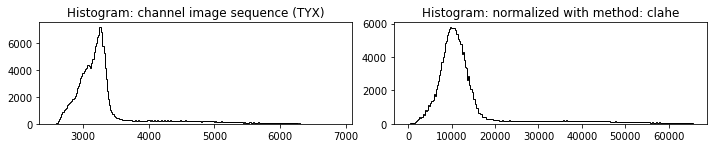

In [23]:
fig, ax = plt.subplots(1,2, figsize = (10,2))
fig.tight_layout()
ax[0].hist(channel_sequence_to_normalize.ravel(), bins=256, histtype='step', color='black')
ax[0].set_title("Histogram: channel image sequence (TYX)")
ax[1].hist(channel_sequence_norm.ravel(), bins=256, histtype='step', color='black')
ax[1].set_title('Histogram: normalized with method: ' + norm_method)

plt.show()

#### Save images 

3 images are saved - 
- whole image with calibration 
- cropped image with all dimensions TCYX 
- cropped normalized image of the specified channel TYX

In [41]:
# extract time info 
time_stamp = datetime.now().strftime("%Y%m%d_%H-%M")

In [42]:
# prepare name for saving
imagename = os.path.splitext(os.path.basename(filenames[0]))[0]
parts = imagename.split("_t000000") 

savename_full = parts[0] + "_t=ALL" + parts[1] + ".tif"
savename_cropped = time_stamp + "__" + parts[0] + "_t"+ str(time_range_min) + "-t" + \
                str(time_range_max) + parts[1] + ".tif"

savename_norm = time_stamp + "__" + parts[0] + "_t"+ str(time_range_min) + "-t" + \
                str(time_range_max) + "_c" + str(channel_to_normalize) + "_norm" + parts[1] + ".tif"
        
saveImageIJCompatible(image_sequence, outputdir, savename_full, 
                      calib, frame_interval, axes= 'TCYX')                          # full image
saveImageIJCompatible(cropped_imagesequence, outputdir, savename_cropped, 
                      calib, frame_interval, axes= 'TCYX')                          # cropped image 
saveImageIJCompatible(channel_sequence_norm, outputdir, savename_norm, calib, 
                      frame_interval, axes= 'TYX')                                  # cropped normalized ch image

## Image registration 

- Drift correction on the normalized channel based on stackreg 
- More information: https://pypi.org/project/pystackreg/ 



In [43]:
img0 = channel_sequence_norm # 3 dimensions : frames x width x height

sr = StackReg(StackReg.TRANSLATION)

# register each frame to the previous (already registered) one
# this is what the original StackReg ImageJ plugin uses
tmats = sr.register_stack(img0, reference='previous')
out_previous = sr.transform_stack(img0)

savename_norm_reg = time_stamp + "__" + parts[0] + "_t"+ str(time_range_min) + "-t" + str(time_range_max) + "_c" + \
                    str(channel_to_normalize) + "_norm_registered" + parts[1] + ".tif"

saveImageIJCompatible(out_previous.astype(np.uint16), outputdir, savename_norm_reg, 
                      calib, frame_interval, axes= 'TYX')  

### User input: Set True or False to normalize and register other channel

If set to True - 
- The other channel is normalized 
- Registered to previously drift corrected channel 
- Saved as single channel as well as hyperstack with both channels merged 

In [44]:
normalize_and_register_other_channel = True     # set it to True or False

# ------ Nothing to change ----------------------

# create empty hyperstack 
merged = np.zeros(cropped_imagesequence.shape)
merged[:, channel_to_normalize, :, :] = out_previous

if normalize_and_register_other_channel:
    
    # find out the other channel no and extract
    other_ch_no = 0 if channel_to_normalize == 1 else 1 
    ch_sequence = cropped_imagesequence[:, other_ch_no, :, :]
    
    # normalize
    ch_sequence_norm = getNormalizedSequence(ch_sequence, method = norm_method, kernelsize = kernelsize)
    
    # register using the transformation matrix from other channel
    img1 = sr.transform_stack(ch_sequence_norm, tmats=tmats)
    
    # save image 
    savename_norm_reg1 = time_stamp + "__" + parts[0] + "_t"+ str(time_range_min) + "-t" + str(time_range_max) + "_c" + \
                    str(other_ch_no) + "_norm_registered" + parts[1] + ".tif"
    saveImageIJCompatible(img1.astype(np.uint16), outputdir, savename_norm_reg1, 
                          calib, frame_interval, axes= 'TYX') 
    
    # save hyperstack
    merged[:, other_ch_no, :, :] = img1  
    savename_norm_reg_merged = time_stamp + "__" + parts[0] + "_t"+ str(time_range_min) + "-t" + str(time_range_max) + "_c=ALL" + \
                    "_norm_registered_merged" + parts[1] + ".tif"
    
    saveImageIJCompatible(merged.astype(np.uint16), outputdir, savename_norm_reg_merged, 
                          calib, frame_interval, axes= 'TCYX')  
    

Histogram normalization done. Shape cropped-normalized image (TYX):  (5, 255, 263)
